# Load libraries and data

In [2]:
import scipy.io as scio
from scipy.interpolate import CubicSpline, UnivariateSpline
from scipy.signal import savgol_filter
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
data = scio.loadmat('../Data/tissue3_1.mat')
calibration = scio.loadmat('../Data/cal_14.mat')

In [4]:
spectra = data['map_t3']
spectrum = spectra[10,10,:]
wavenumbers = calibration['Cal'][0][0][0]/10

Text(0.5, 0, 'Raman shift [cm-1]')

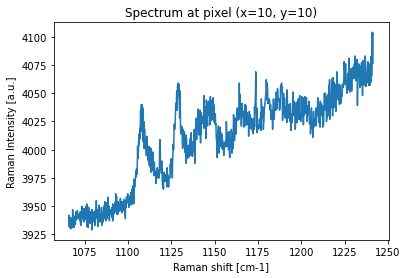

In [9]:
plt.figure(figsize=(6,4))
plt.plot(wavenumbers, spectrum, linewidth=1.5)
plt.title('Spectrum at pixel (x=10, y=10)')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

# Moving average

Parameters:
- Window size

In [102]:
moving_avg = spectrum.copy()
for i in range(4,1020):
    moving_avg[i] = np.mean(spectrum[i-4:i+4])

Text(0.5, 0, 'Raman shift [cm-1]')

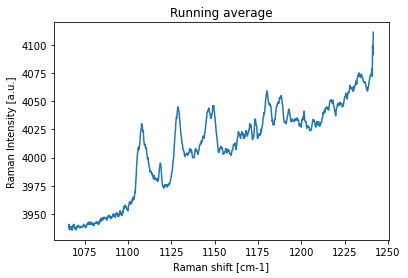

In [141]:
plt.figure()
plt.plot(wavenumbers, moving_avg, linewidth=1.5)
plt.title('Running average')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

# Savitzky-Golay

Parameters:
- Window size
- Order of polynomial

In [135]:
sav_gol = spectrum.copy()
sav_gol = savgol_filter(sav_gol, 9, 3, mode='nearest')

Text(0.5, 0, 'Raman shift [cm-1]')

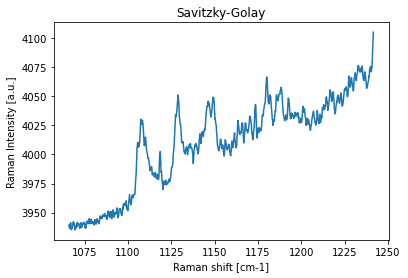

In [140]:
plt.figure()
plt.plot(wavenumbers, sav_gol, linewidth=1.5)
plt.title('Savitzky-Golay')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

# Cubic splines 


In [106]:
spline = UnivariateSpline(wavenumbers.flatten(),spectrum)
spline.set_smoothing_factor(1024*35)
cubic_spline = spline(wavenumbers)

Text(0.5, 0, 'Raman shift [cm-1]')

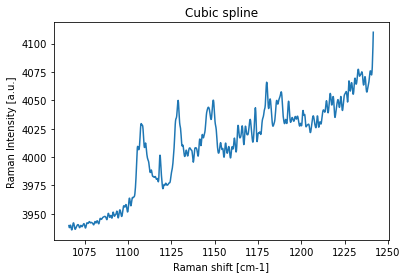

In [139]:
plt.figure()
plt.plot(wavenumbers, cubic_spline, linewidth=1.5)
plt.title('Cubic spline')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

# Single value decomposition 

In [108]:
m = 20
r = 5
x = spectrum
gap = x[-1] - x[0]
trend = np.linspace(0, gap, 1024)

In [109]:
# Expand into matrix with m rows 
x = x - trend
x_ext = np.hstack((x, x[:m-1]))
shape = (m, 1024)
strides = (x_ext.strides[0], x_ext.strides[0])
X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)

In [110]:
U, s, Vh = np.linalg.svd(X, full_matrices=False)
A = U[:,:r] @ np.diag(s[:r]) @ Vh[:r]

In [111]:
# Reduce into array
A_ext = np.hstack((A[:,-m+1:], A))
strides = (A_ext.strides[0]-A_ext.strides[1], A_ext.strides[1])
svd_smooth = np.mean(np.lib.stride_tricks.as_strided(A_ext[:,m-1:], A.shape, strides), axis=0)
svd_smooth = svd_smooth + trend

Text(0.5, 0, 'Raman shift [cm-1]')

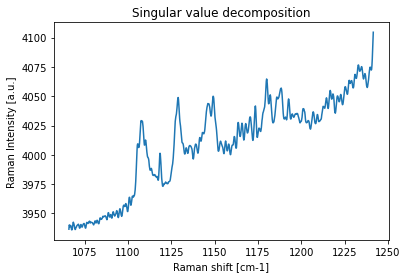

In [142]:
plt.figure()
plt.plot(wavenumbers, svd_smooth, linewidth=1.5)
plt.title('Singular value decomposition')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')

# Spatial averaging


In [132]:
smoothing_filter = [[1, 4,  7,   4, 1],
                    [4, 16, 26, 16, 4],
                    [7, 26, 41, 26, 7],
                    [4, 16, 26, 16, 4],
                    [1, 4,  7,   4, 1]]

smoothing_spectra = spectra[23:28,23:28,:]

space_avg = np.zeros(1024)

for i in range(5):
    for j in range(5):
        space_avg += 1/273 * smoothing_filter[i][j] * smoothing_spectra[i,j,:]

Text(0.5, 0, 'Raman shift [cm-1]')

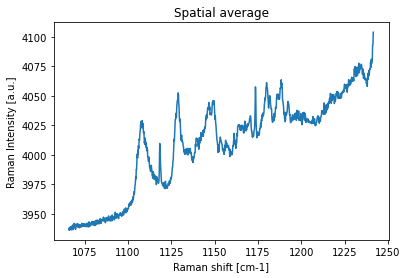

In [143]:
plt.figure()
plt.plot(wavenumbers, space_avg, linewidth=1.5)

plt.title('Spatial average')
plt.ylabel('Raman Intensity [a.u.]')
plt.xlabel('Raman shift [cm-1]')